### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()
print STAT['TMIN'].keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
['std', 'UnDef', 'E', 'Cov', 'high1000', 'NE', 'O', 'low100', 'NO', 'high100', 'eigvec', 'low1000', 'Var', 'eigval', 'mean', 'SortedVals', 'Mean']
12619
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    42|[40 4C 80 4D 80 5...|1899.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    17|[80 D1 80 C9 E0 5...|1900.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    16|[A0 D3 00 00 00 5...|1901.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       TMAX|USC00109698|    37|[80 54 E0 50 00 4...|1902.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00024126')
# Query="SELECT * FROM weather\n\tWHERE measurement='%s' and latitude > 41.18 and latitude < 41.20 and longitude > -112.3 and longitude < -111.7"%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
# print T[0]

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USW00024126'
18 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1362.5| 41.1961|-112.0114|       PRCP|USW00024126|     0|[00 00 50 54 00 0...|1948.0|SBSSBSBB|
|   1362.5| 41.1961|-112.0114|       PRCP|USW00024126|     0|[70 54 00 00 00 0...|1949.0|SBSSBSBB|
|   1362.5| 41.1961|-112.0114|       PRCP|USW00024126|     0|[00 48 80 4F 00 0...|1950.0|SBSSBSBB|
|   1362.5| 41.1961|-112.0114|       PRCP|USW00024126|     1|[00 00 00 00 80 4...|1951.0|SBSSBSBB|
|   1362.5| 41.1961|-112.0114|       PRCP|USW00024126|     0|[00 45 00 00 00 0...|1999.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



(18, 365)

### Script for plotting yearly plots

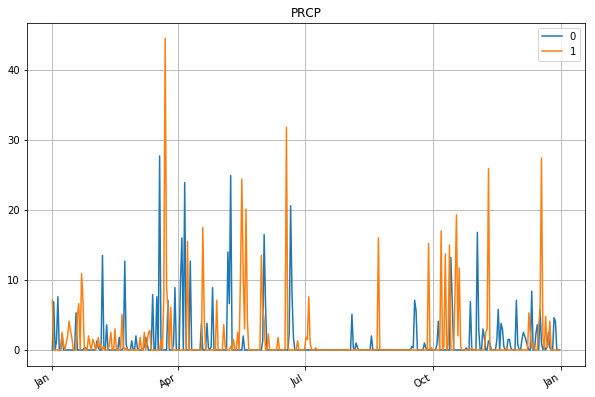

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
# print T[:2,:].transpose()

YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    print valid_m.shape
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

(365,)
(365,)


/Users/GuoCheng/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


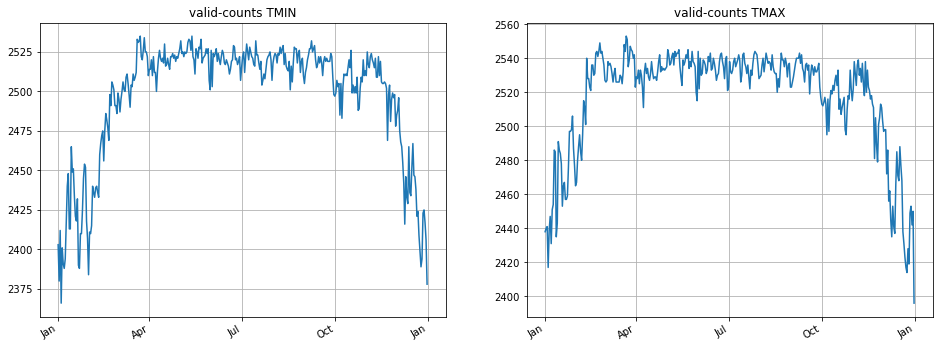

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

(365,)
(365,)


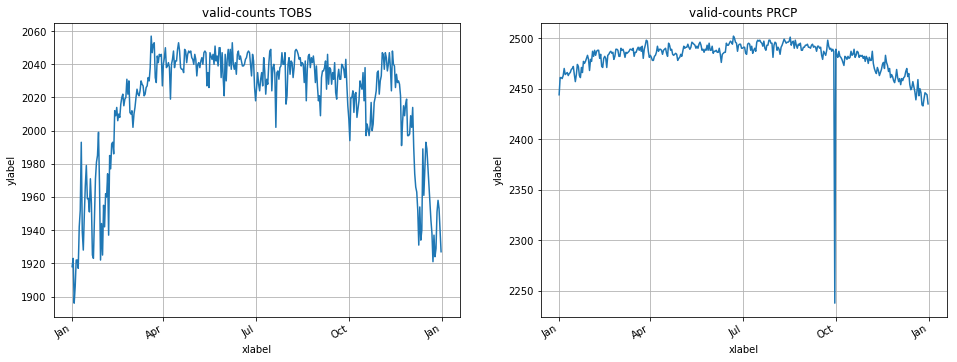

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

(365,)
(365,)


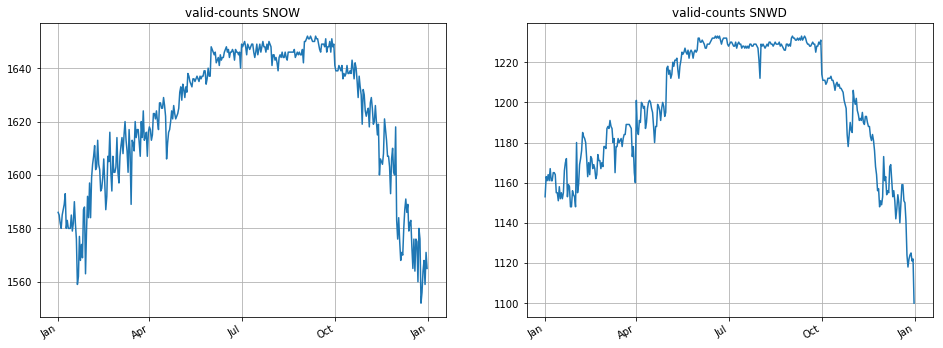

In [6]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [16]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    axis.set_ylabel("Millimeters per Day")
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=["mean-std","mean","mean+std"])

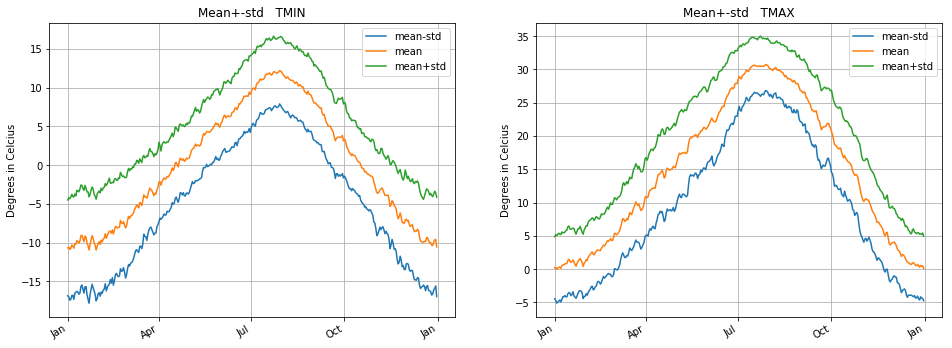

In [8]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

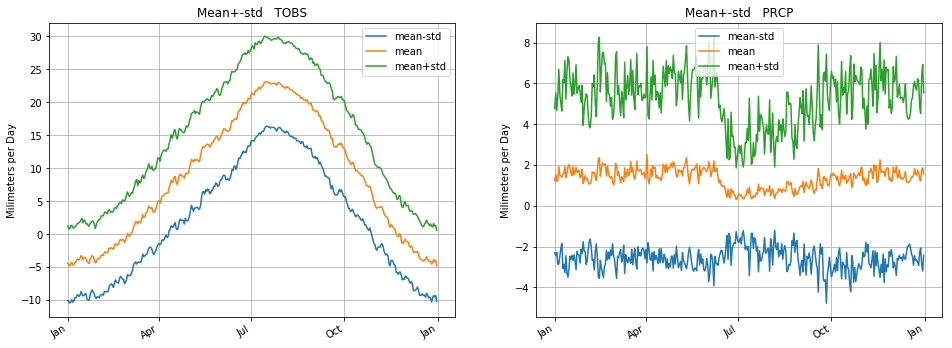

In [18]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

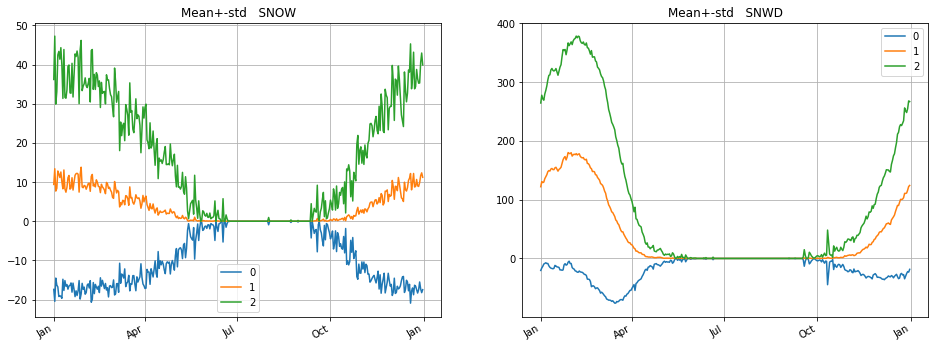

In [42]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [19]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    EVAL = STAT[m]['eigval']
    print EVAL[:3]
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

[ 270547.31484672   33050.59690386   24441.35989971]
[ 249783.50092341   40763.33865972   32250.01276244]


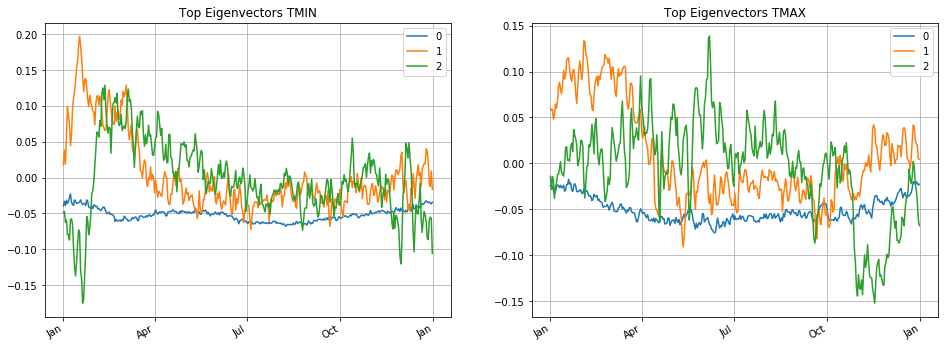

In [20]:
plot_pair(['TMIN','TMAX'],plot_eigen)

[ 735681.76361424   44518.95306086   29109.31004546]
[ 26620.48743498  14924.09876134  12967.36010699]


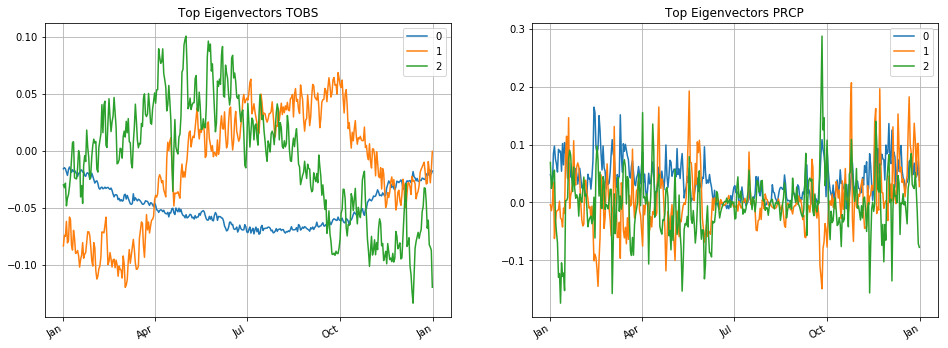

In [21]:
plot_pair(['TOBS','PRCP'],plot_eigen)

[ 3258.50039568  2332.71326161  2085.05861248]
[ 2049400.84041967   257658.27957637   219215.32787096]


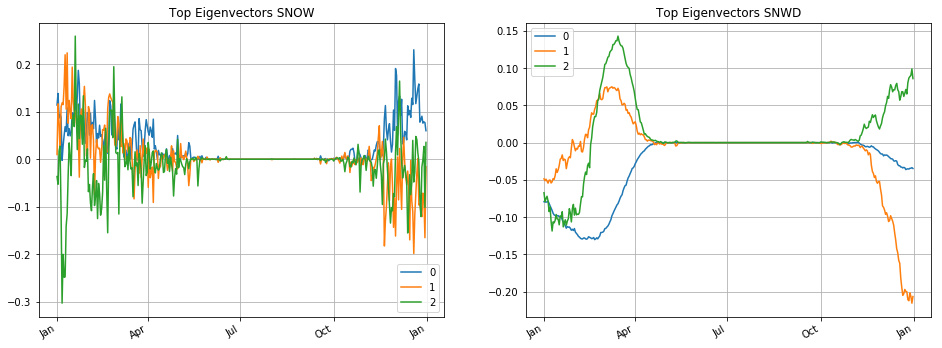

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [23]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

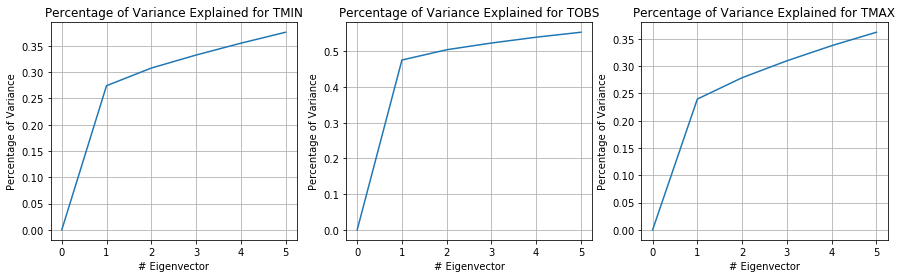

In [24]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

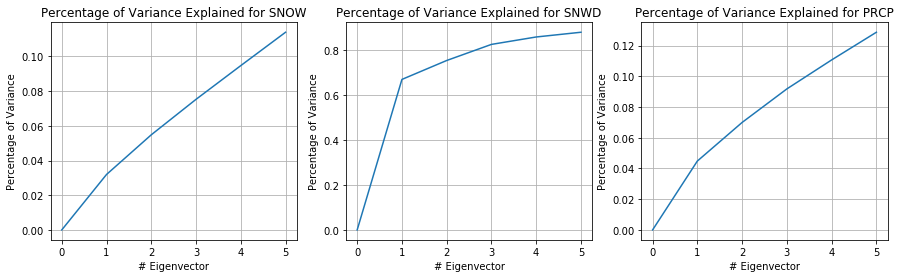

In [25]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()